In [133]:
import sklearn

In [134]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

In [135]:
len(X), len(y)

(1000, 1000)

In [136]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [137]:
# Make Dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


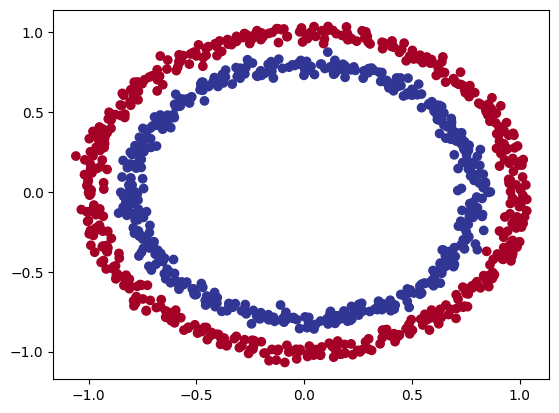

In [138]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [139]:
# 1.1 Check input and output shapes
X.shape, y.shape

((1000, 2), (1000,))

In [140]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"X shape: {X_sample.shape}, y shape: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
X shape: (2,), y shape: ()


In [141]:
# 1.2 Turn data into tensors and create train and test splits
import torch
torch.__version__

'2.0.1+cu117'

In [142]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [143]:
X = torch.from_numpy(X).type(torch.float)

In [144]:
y = torch.from_numpy(y).type(torch.float)

In [145]:
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [146]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [147]:
# 2. Build a model
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [148]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # create nn.Linear layers capable
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [149]:
# Replicate the model using Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [150]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [151]:
# Make predictions
with torch.no_grad():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [152]:
y_test[:10], X_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]))

In [153]:
# 2.1 Setup Loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss() # sigmoid function built in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)


In [154]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [155]:
# Train Model
# raw logit -> prediction probabilities -> prediction label
# convert logit into probabilities (sigmoid or softmax)
# convert probabilities into prediction labels by round or take argmax

with torch.no_grad():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [156]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [157]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [158]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [159]:
# Build a training and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.no_grad():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")


Epoch: 0 | Train Loss: 0.69796 | Train Acc: 51.88 | Test Loss: 0.69460 | Test Acc: 57.50%
Epoch: 10 | Train Loss: 0.69768 | Train Acc: 52.00 | Test Loss: 0.69438 | Test Acc: 58.00%
Epoch: 20 | Train Loss: 0.69742 | Train Acc: 52.00 | Test Loss: 0.69418 | Test Acc: 57.50%
Epoch: 30 | Train Loss: 0.69717 | Train Acc: 52.00 | Test Loss: 0.69401 | Test Acc: 56.50%
Epoch: 40 | Train Loss: 0.69695 | Train Acc: 51.62 | Test Loss: 0.69385 | Test Acc: 56.50%
Epoch: 50 | Train Loss: 0.69675 | Train Acc: 51.38 | Test Loss: 0.69370 | Test Acc: 56.00%
Epoch: 60 | Train Loss: 0.69656 | Train Acc: 51.38 | Test Loss: 0.69357 | Test Acc: 56.00%
Epoch: 70 | Train Loss: 0.69638 | Train Acc: 51.38 | Test Loss: 0.69345 | Test Acc: 56.50%
Epoch: 80 | Train Loss: 0.69621 | Train Acc: 51.25 | Test Loss: 0.69334 | Test Acc: 56.50%
Epoch: 90 | Train Loss: 0.69606 | Train Acc: 51.38 | Test Loss: 0.69324 | Test Acc: 55.00%


In [160]:
# Visualize
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


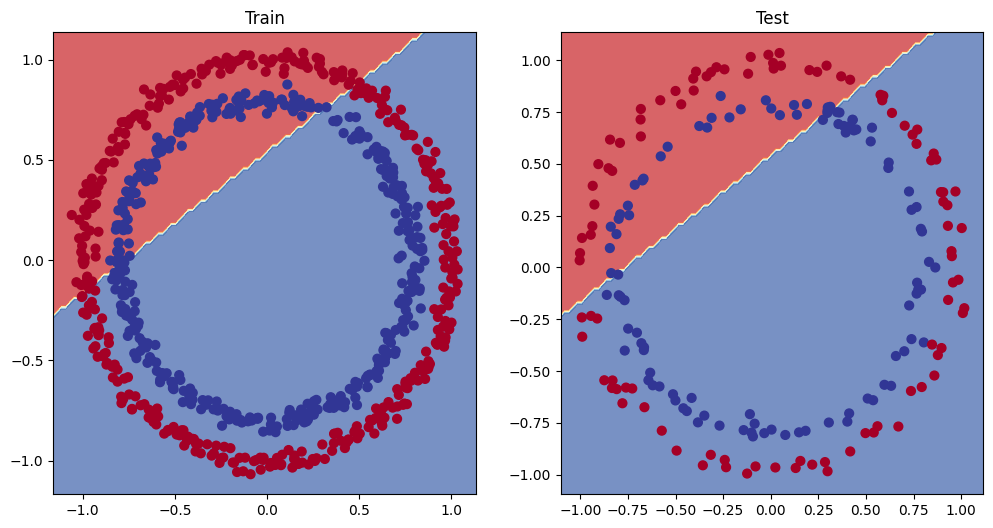

In [161]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_0, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_0, X=X_test, y=y_test)

In [162]:
# 5. Improving a model (from a model perspective)
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [163]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [164]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.no_grad():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69396 | Train Acc: 50.88 | Test Loss: 0.69261 | Test Acc: 51.00%
Epoch: 100 | Train Loss: 0.69305 | Train Acc: 50.38 | Test Loss: 0.69379 | Test Acc: 48.00%
Epoch: 200 | Train Loss: 0.69299 | Train Acc: 51.12 | Test Loss: 0.69437 | Test Acc: 46.00%
Epoch: 300 | Train Loss: 0.69298 | Train Acc: 51.62 | Test Loss: 0.69458 | Test Acc: 45.00%
Epoch: 400 | Train Loss: 0.69298 | Train Acc: 51.12 | Test Loss: 0.69465 | Test Acc: 46.00%
Epoch: 500 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69467 | Test Acc: 46.00%
Epoch: 600 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 700 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 800 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00%
Epoch: 900 | Train Loss: 0.69298 | Train Acc: 51.00 | Test Loss: 0.69468 | Test Acc: 46.00%


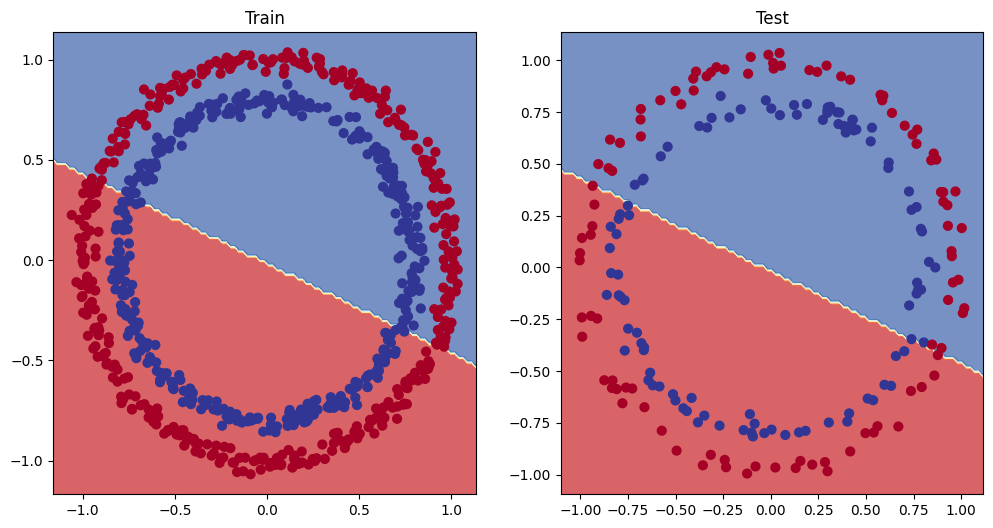

In [165]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_1, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_1, X=X_test, y=y_test)

In [166]:
# See if our model can fit a straight line
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

print(len(X_regression), len(y_regression))
X_regression[:5], y_regression[:5]

100 100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [167]:
# Create train and test splits
traint_split = int(0.8 * len(X_regression))
X_train_regression, X_test_regression = X_regression[:traint_split], X_regression[traint_split:]
y_train_regression, y_test_regression = y_regression[:traint_split], y_regression[traint_split:]

len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

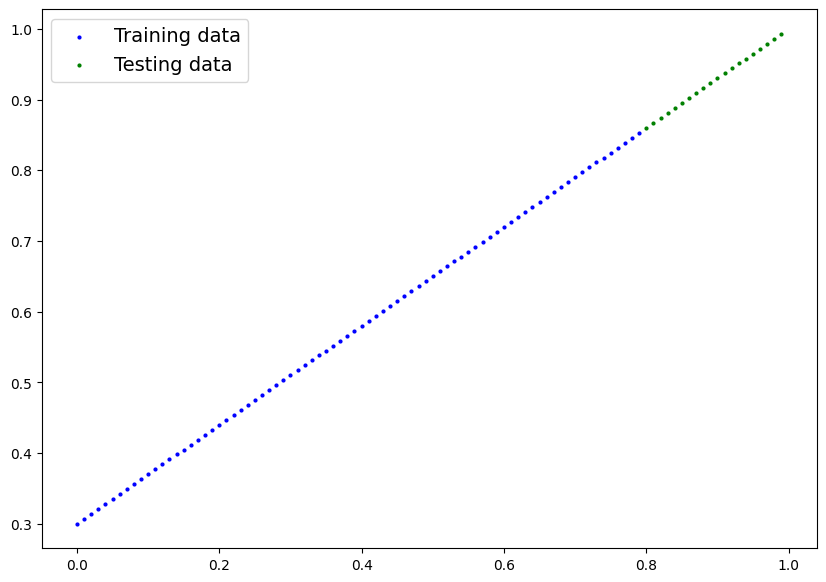

In [168]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

In [169]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [170]:
# Adjust model_1 to fit a straight line
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [171]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)

In [172]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    model_2.train()
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()
    with torch.no_grad():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Train Loss: 0.75986 | Test Loss: 0.91103
Epoch: 100 | Train Loss: 0.02858 | Test Loss: 0.00081
Epoch: 200 | Train Loss: 0.02533 | Test Loss: 0.00209
Epoch: 300 | Train Loss: 0.02137 | Test Loss: 0.00305
Epoch: 400 | Train Loss: 0.01964 | Test Loss: 0.00341
Epoch: 500 | Train Loss: 0.01940 | Test Loss: 0.00387
Epoch: 600 | Train Loss: 0.01903 | Test Loss: 0.00379
Epoch: 700 | Train Loss: 0.01878 | Test Loss: 0.00381
Epoch: 800 | Train Loss: 0.01840 | Test Loss: 0.00329
Epoch: 900 | Train Loss: 0.01798 | Test Loss: 0.00360


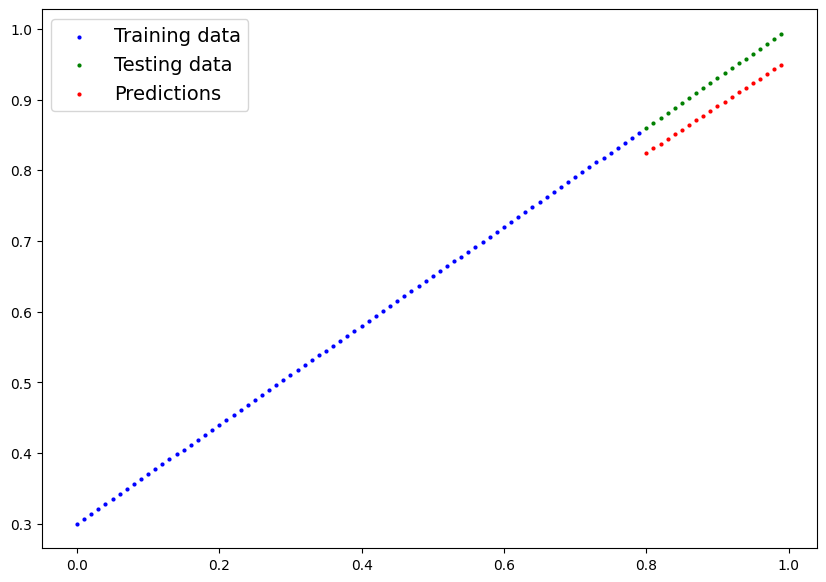

In [173]:
# Turn on evaluation mode
model_2.eval()

with torch.no_grad():
    y_preds = model_2(X_test_regression)
plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(), test_data=X_test_regression.cpu(), test_labels=y_test_regression.cpu(), predictions=y_preds.cpu())

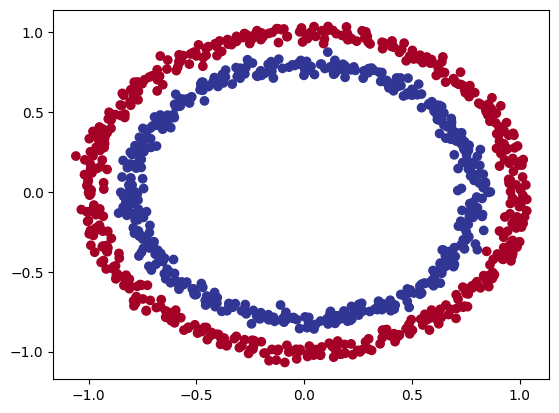

In [174]:
# The missing piece: non-linearity
# Recreating non-linear data

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [175]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [176]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [177]:
# Loss and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [178]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_3.train()
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.no_grad():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69295 | Train Acc: 50.00 | Test Loss: 0.69319 | Test Acc: 50.00%
Epoch: 100 | Train Loss: 0.69115 | Train Acc: 52.88 | Test Loss: 0.69102 | Test Acc: 52.50%
Epoch: 200 | Train Loss: 0.68977 | Train Acc: 53.37 | Test Loss: 0.68940 | Test Acc: 55.00%
Epoch: 300 | Train Loss: 0.68795 | Train Acc: 53.00 | Test Loss: 0.68723 | Test Acc: 56.00%
Epoch: 400 | Train Loss: 0.68517 | Train Acc: 52.75 | Test Loss: 0.68411 | Test Acc: 56.50%
Epoch: 500 | Train Loss: 0.68102 | Train Acc: 52.75 | Test Loss: 0.67941 | Test Acc: 56.50%
Epoch: 600 | Train Loss: 0.67515 | Train Acc: 54.50 | Test Loss: 0.67285 | Test Acc: 56.00%
Epoch: 700 | Train Loss: 0.66659 | Train Acc: 58.38 | Test Loss: 0.66322 | Test Acc: 59.00%
Epoch: 800 | Train Loss: 0.65160 | Train Acc: 64.00 | Test Loss: 0.64757 | Test Acc: 67.50%
Epoch: 900 | Train Loss: 0.62362 | Train Acc: 74.00 | Test Loss: 0.62145 | Test Acc: 79.00%


In [179]:
# Evaluate
model_3.eval()
with torch.no_grad():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]


(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

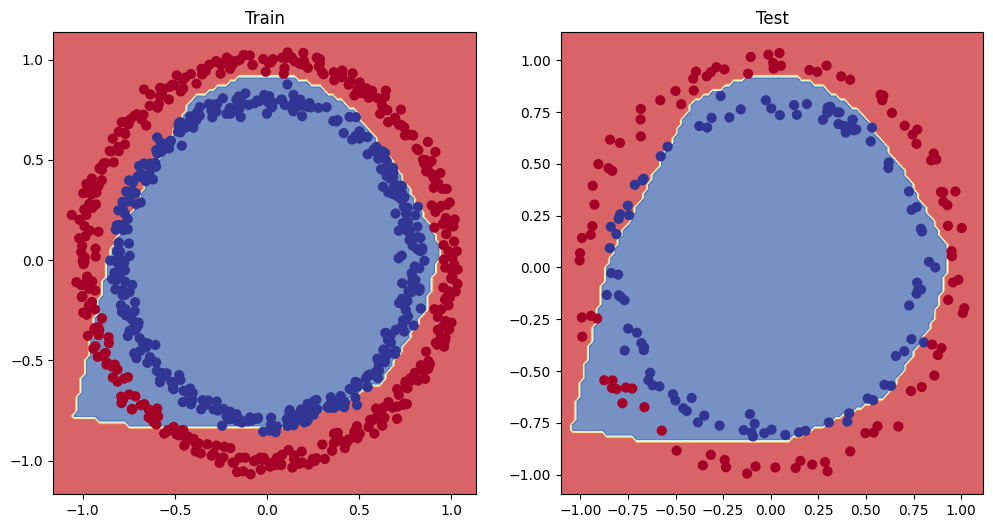

In [180]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_3, X=X_test, y=y_test)

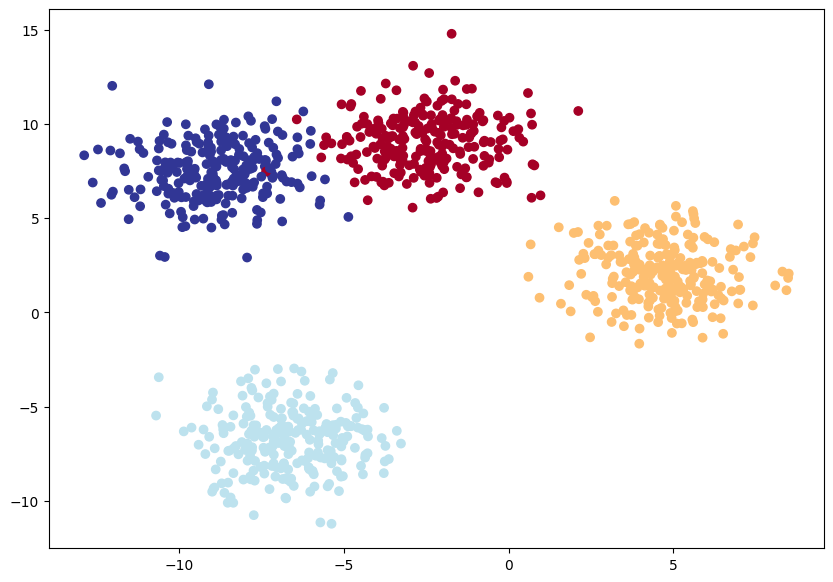

In [181]:
# Multi-class dataset
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, centers=NUM_CLASSES, n_features=NUM_FEATURES, random_state=RANDOM_SEED, cluster_std=1.5)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [182]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [183]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.01)

In [184]:
model_4.eval()
with torch.no_grad():
    y_logits = model_4(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [185]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [186]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [187]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [188]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [189]:
# Fit the model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_4.eval()
    with torch.no_grad():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Train Acc: {acc:.4f}, Test Loss: {test_loss.item():.4f}, Test Acc: {test_acc:.4f}")

Epoch: 1/1000, Train Loss: 1.1588, Train Acc: 40.3750, Test Loss: 1.1472, Test Acc: 38.5000
Epoch: 11/1000, Train Loss: 1.0649, Train Acc: 55.3750, Test Loss: 1.0684, Test Acc: 50.5000
Epoch: 21/1000, Train Loss: 0.9819, Train Acc: 62.6250, Test Loss: 0.9976, Test Acc: 57.5000
Epoch: 31/1000, Train Loss: 0.9114, Train Acc: 70.5000, Test Loss: 0.9360, Test Acc: 67.0000
Epoch: 41/1000, Train Loss: 0.8529, Train Acc: 88.3750, Test Loss: 0.8834, Test Acc: 87.5000
Epoch: 51/1000, Train Loss: 0.8043, Train Acc: 92.1250, Test Loss: 0.8385, Test Acc: 93.0000
Epoch: 61/1000, Train Loss: 0.7635, Train Acc: 93.6250, Test Loss: 0.7998, Test Acc: 94.5000
Epoch: 71/1000, Train Loss: 0.7285, Train Acc: 94.8750, Test Loss: 0.7659, Test Acc: 95.0000
Epoch: 81/1000, Train Loss: 0.6977, Train Acc: 95.6250, Test Loss: 0.7356, Test Acc: 95.0000
Epoch: 91/1000, Train Loss: 0.6698, Train Acc: 96.3750, Test Loss: 0.7076, Test Acc: 96.5000
Epoch: 101/1000, Train Loss: 0.6438, Train Acc: 96.8750, Test Loss: 0.6

In [190]:
# Making and evaluating predictions with a PyTorch multi-class model
model_4.eval()
with torch.no_grad():
    y_preds = torch.softmax(model_4(X_blob_test), dim=1).argmax(dim=1)
y_preds[:10], y_blob_test[:10]

(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0'))

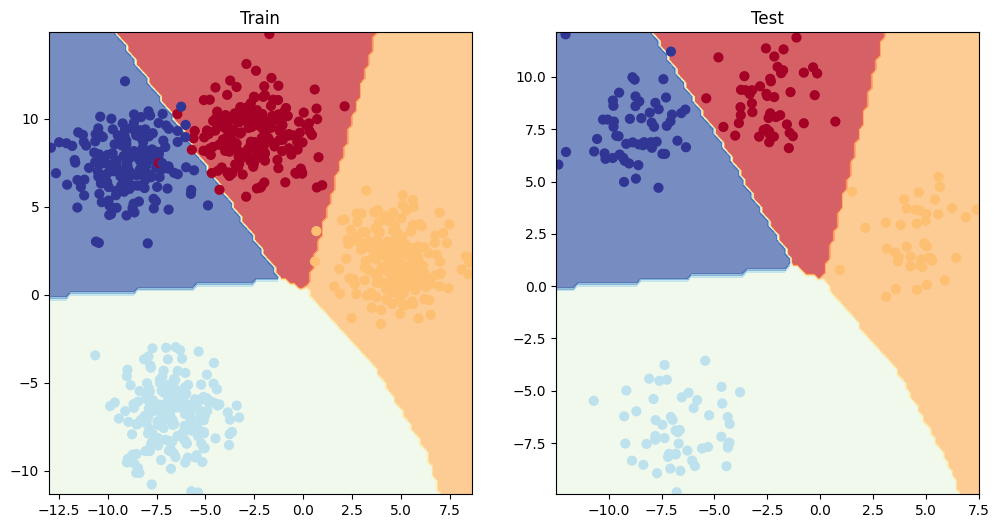

In [191]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model_4, X=X_blob_train, y=y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model_4, X=X_blob_test, y=y_blob_test)